# Quantum Concepts: Open quantum systems

$$
    \newcommand{\ket}[1]{\left|#1\right\rangle}
    \newcommand{\bra}[1]{\left\langle#1\right|}
    \newcommand{\Tr}[0]{\operatorname{Tr}}
$$

## Introduction

Often in quantum computing, we'll talk about quantum systems that are very well isolated from their environments, such that no noise affects the qubits in such systems. We say that quantum systems that are isolated in this way are _closed quantum systems_.

By contrast, a device that is subject to some amount of noise from its environment is an _open quantum system_. In this notebook, we'll cover some of the basics on representing the states of open quantum systems, and how quantum operations affect the states of open systems.

## Preamble

We start by importing the [QuTiP](https://qutip.org/) library, a popular Python library for manipulating states and processes of closed and open quantum systems.

In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt

We next import Q# ↔ Python interoperability and enable the experimental noisy simulation feature.

In [2]:
import qsharp

In [3]:
import qsharp.experimental
qsharp.experimental.enable_noisy_simulation()

We'll also open a few Q# namespaces that will be helpful to us in the rest of the notebook.

In [4]:
%%qsharp

open Microsoft.Quantum.Diagnostics;
open Microsoft.Quantum.Measurement;
open Microsoft.Quantum.Random;

## Revisiting quantum states

Before proceeding to discuss representing open quantum systems, it's helpful to quickly revisit representations of closed quantum systems. In particular, we can represent the state of an $n$-qubit register as a vector of $2^n$ complex numbers. For example, the state of a single qubit can be written as a vector of the form
$$
\begin{aligned}
    \ket{\psi} = \alpha \ket{0} + \beta \ket{1} = \left( \begin{matrix}
        \alpha \\ \beta
    \end{matrix} \right)
\end{aligned}
$$
for complex numbers $\alpha$ and $\beta$ such that $|\alpha|^2 + |\beta|^2 = 1$.

In Q#, we can ask the default simulator to dump the state that it uses to simulate quantum programs, getting back a description of that state as a vector of this form.

In [5]:
%%qsharp
operation DumpPlus() : Unit {
    use q = Qubit();
    within {
        H(q);
    } apply {
        DumpMachine();
    }
}

In [6]:
DumpPlus.simulate()

|0⟩	0.7071067811865476 + 0𝑖
|1⟩	0.7071067811865476 + 0𝑖

()

The above diagnostic tells us that at the point when `DumpMachine` is called, the state of `q` is given by the vector $\ket{+} \mathrel{:=} (\ket{0} + \ket{1}) / \sqrt{2} \approx 0.7071 \ket{0} + 0.7071 \ket{1}$.

We can also write this state in QuTiP notation, using `qt.basis(2, i)` to represent $\ket{i}$ on a single qubit:

In [7]:
ket0 = qt.basis(2, 0)
ket1 = qt.basis(2, 1)
ket_plus = (1 / np.sqrt(2)) * (ket0 + ket1)
ket_plus

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.70710678]
 [0.70710678]]

When we measure a qubit in the $\ket{+}$ state in the $Z$-basis, we get `Zero` and `One` with equal probability:

In [8]:
%%qsharp

operation SampleRandomBit() : Result {
    use q = Qubit();
    H(q);
    return MResetZ(q);
}

In [9]:
sum(SampleRandomBit.simulate() for _ in range(100))

54

Importantly, though, the $\ket{+}$ state is not inherently random — we can determinstically return to the $\ket{0}$ state by applying another `H` operation:

In [10]:
%%qsharp

operation ApplyHTwiceAndMeasure() : Result {
    use q = Qubit();
    H(q);
    H(q);
    return MResetZ(q);
}

In [11]:
sum(ApplyHTwiceAndMeasure.simulate() for _ in range(100))

0

## Preparing random states

As opposed to preparing $\ket{+}$ and measuring, we could also consider flipping a coin classically, and using the outcome to prepare either the $\ket{0}$ or $\ket{1}$ state.

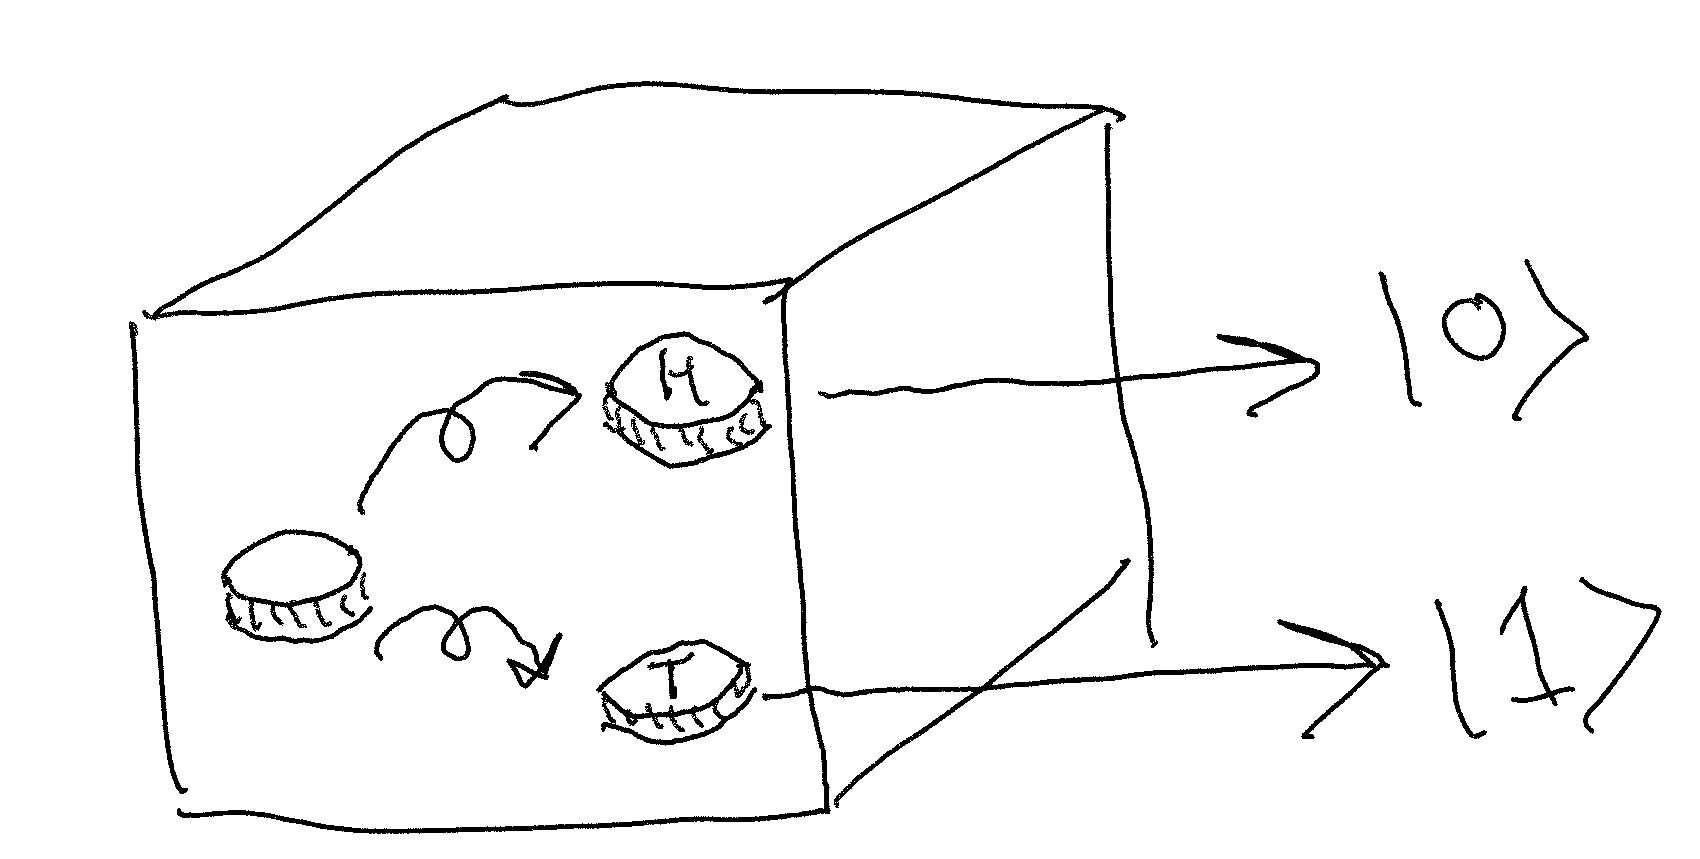

In [12]:
%%qsharp

operation PrepareAndMeasureRandomState() : Result {
    use q = Qubit();
    if DrawRandomBool(0.5) {
        X(q);
    }
    return MResetZ(q);
}

Doing so, we get the same 50/50 outcomes that we saw before:

In [13]:
sum(PrepareAndMeasureRandomState.simulate() for _ in range(100))

45

This time, however, when we apply `H` again, we don't get back to a determinstic outcome:

In [14]:
%%qsharp

operation ApplyHToRandomStateAndMeasure() : Result {
    use q = Qubit();
    if DrawRandomBool(0.5) {
        X(q);
    }
    H(q); // ← Doesn't get us back to |0⟩!
    return MResetZ(q);
}

In [15]:
sum(ApplyHToRandomStateAndMeasure.simulate() for _ in range(100))

42

As it turns out, there is no single vector that we can use to represent the state prepared by `ApplyHToRandomStateAndMeasure` unless we know the outcome of the random coin flip (`DrawRandomBool(0.5)`) in our description. If we don't know the outcome of the coin flip, we have an _ensemble_ of state vectors,
$$
\begin{aligned}
    \rho =
        \left\{
            \ket{0} \text{ with probability 50%}, \quad
            \ket{1} \text{ with probability 50%}
        \right\}.
\end{aligned}
$$

Just as with the quantum states that we're used to, we can predict measurements of such ensembles using Born's rule,
$$
\begin{aligned}
    \Pr(\phi | \psi) & = \left|\left\langle \phi | \psi \right\rangle\right|^2 \\
                     & = \left\langle \phi | \psi \right\rangle \left\langle \psi | \phi \right\rangle.
\end{aligned}
$$
The trick here is to average over the different state vectors that could be prepared by our operation:
$$
\begin{aligned}
    \Pr(\phi | \rho)
        & = \mathbb{E}_{\psi \sim \rho} \left[
            \Pr(\phi | \psi)
        \right] \\
        & = \mathbb{E}_{\psi \sim \rho} \left [
            \left\langle \phi | \psi \right\rangle \left\langle \psi | \phi \right\rangle
        \right] \\
        & = \sum_i \Pr(\psi_i) \left\langle \phi | \psi_i \right\rangle \left\langle \psi_i | \phi \right\rangle \\
        & = \left\langle
            \phi \Bigg| \left(
                \sum_i \Pr(\psi_i) \ket{\psi_i} \bra{\psi_i}
            \right) \Bigg| \phi
        \right\rangle.
\end{aligned}
$$

Factoring out $\bra{\phi}$ and $\ket{\phi}$ in the last step gives us a neat new way of writing out ensembles of state vectors as matrices called _density operators_. For example, the ensemble $\rho$ above can also be written out as a density operator,
$$
\begin{aligned}
    \rho & = \sum_i \Pr(\psi_i) \ket{\psi_i} \bra{\psi_i} \\
         & = \frac12 \ket{0} \bra{0} + \frac12 \ket{1} \bra{1} \\
         & = \frac12 \left( \begin{matrix}
             1 & 0 \\ 0 & 1
         \end{matrix} \right).
\end{aligned}
$$

Using density operators, we can write both ensembles of states, as well as the kinds of closed system states that we're used to as _projectors_ on to those state vectors. For example, the $\ket{+}$ state from above can be written as the density operator
$$
\begin{aligned}
    \ket{+}\bra{+} = 
    \frac12 \left( \begin{matrix}
        1 & 1 \\ 1 & 1
    \end{matrix} \right).
\end{aligned}
$$

That is, even though both `SampleRandomBit` and `PrepareAndMeasureRandomState` both prepare density operators with the same diagonal elements (and thus have the same measurement probabilies in the $Z$-basis), the two density operators have different off-diagonal elements. We say that density operators in general represent _mixed states_, and that states that can be written as $\ket{\psi}\bra{\psi}$ for some state vector $\ket{\psi}$ (e.g.: $\ket{+}\bra{+}$)  are _pure states_.

To tell how close a given density operator $\rho$ is to being pure, we can look at the trace (that is the sum of the diagonal elements) of $\rho^2$:

In [16]:
rho_mixed = (ket0 * ket0.dag() + ket1 * ket1.dag()) / 2
rho_mixed

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5 0. ]
 [0.  0.5]]

The trace of $\rho$ is written as $\Tr(\rho)$ and can be calculated using QuTiP's `.tr()` method:

In [17]:
(rho_mixed ** 2).tr()

0.5

In [18]:
rho_pure = ket_plus * ket_plus.dag()
rho_pure

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5 0.5]
 [0.5 0.5]]

In [19]:
(rho_pure ** 2).tr()

0.9999999999999996

> #### 💡 TIP
>
> More generally, a given matrix $\rho$ is a valid density operator if:
>
> 1. $\rho$ is a matrix of complex numbers,
> 2. $\rho = \rho^{\dagger}$ (that is, $\rho$ is Hermitian),
> 3. Every eigenvalue $p$ of $\rho$ is $0 <= p <= 1$, and
> 4. All the eigenvalues of $\rho$ sum to 1.
>
> Together, these conditions guarantee that $\rho$ can be thought of as an ensemble, as we saw above. In particular, if $\rho = \sum_i p_i \ket{\psi_i} \bra{\psi_i}$ is an eigenvalue decomposition of $\rho$, then $\rho$ describes the ensemble $\rho = \{\ket{\psi_i} \text{ with probability } p_i\}$.

For single qubit systems, we can even plot mixed states on the Bloch sphere in the same way we plot state vectors — doing so, pure states are those states that lie on the surface of the Bloch sphere, while mixed states in general can be "inside" the Bloch sphere.

<Figure size 432x432 with 0 Axes>

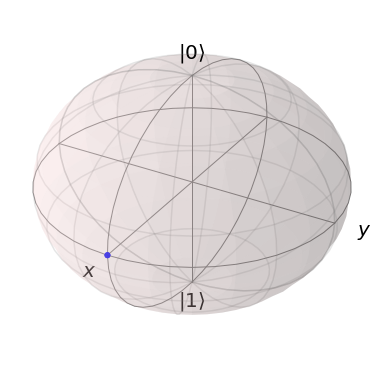

In [20]:
plt.figure(figsize=(6, 6))
bloch = qt.bloch.Bloch()
bloch.add_states([rho_pure], kind='point')
bloch.show()

C:\Users\cgran\Anaconda3\lib\site-packages\qutip\bloch.py:587: RuntimeWarning: invalid value encountered in true_divide
  if any(abs(dist - dist[0]) / dist[0] > 1e-12):


<Figure size 432x432 with 0 Axes>

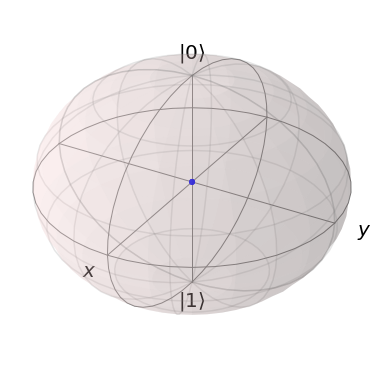

In [21]:
plt.figure(figsize=(6, 6))
bloch = qt.bloch.Bloch()
bloch.add_states([rho_mixed], kind='point')
bloch.show()

We say that the state at the very center of the Bloch sphere is the _maximally mixed state_. Unlike pure states, the maximally mixed state returns 50/50 outcomes for any ideal Pauli measurement.

## Representing quantum processes

Armed with the concept of a mixed state, we can now talk more concretely about how noisy processes affect the state of quantum registers. As before, it helps to take a step and consider how ideal unitary operations affect pure states.

Considering the [`H` operation](https://docs.microsoft.com/qsharp/api/qsharp/microsoft.quantum.intrinsic.h), we can simulate its action on a pure state $\ket{\psi}$ as $H \ket{\psi}$. By direct analogy, we can simulate what `H` does to a density operator by multiplying on the left and right both:
$$
\begin{aligned}
    \rho \longmapsto H\rho H^{\dagger} = H \rho H.
\end{aligned}
$$

More generally, though, we can also represent processes in which one of several unitary operations is applied at random. For example, suppose our `H` operation works 95% of the time, but the other 5% of the time does nothing. Just as we added different preparations together, we can simply add the density operators we get in each case, weighted by the probability of each case:
$$
\begin{aligned}
    \rho \longmapsto 0.95 H \rho H + 0.05 \rho.
\end{aligned}
$$

One way to model this is by thinking of the `H` operation not as being represented by a unitary matrix, but by a function from density operators to density operators
$$
\begin{aligned}
    \Lambda_H(\rho) = H\rho H.
\end{aligned}
$$
Since density functions represent an averge over different preparations, and since averages are linear, such functions must in general must also be linear.

We say that a linear function from density operators to density operators is a _quantum process_.

> **💡 TIP**:
> Quantum processes that can be realized in practice have a few other conditions as well as linearity, known as *complete positivity* and *trace preservingness*. We say that a process that is both completely positive and trace preserving (CPTP) is a _channel_.
>
> You may see this terminology in contexts where the CPTP property is assumed.

There's a few different ways to represent quantum processes, but the one we'll most commonly encounter in working with noise models for open quantum systems is known as _superoperators_. Just as operators are linear functions from vectors to vectors, superoperators are linear functions from operators to operators, and can be written using matrices.

For example, let's use `qt.to_super` to convert a few unitary matrices that we're already used to into superoperators. We start by noting that the 2 × 2 identity operator $𝟙$ we use to simulate the `Microsoft.Quantum.Intrinsic.I` operation is a 4 × 4 identity matrix:

In [22]:
# Convert the 𝟙 matrix used to simulate Microsoft.Quantum.Intrinsic.I (single qubit no-op) into a superoperator.
qt.to_super(qt.qeye(2))

Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = (4, 4), type = super, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

That is, as we would expect, the superoperator we get from the identity operator maps all operators to themselves.

On the other hand, we get something quite different for the $X$ matrix:

In [23]:
# Convert the 𝑋 matrix used to simulate Microsoft.Quantum.Intrinsic.X into a superoperator.
qt.to_super(qt.sigmax())

Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = (4, 4), type = super, isherm = True
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

What's happening above is that each column is a stack of the elements in an operator output by the function $\Lambda_X(\rho) = X \rho X^{\dagger} = X \rho X$.

Since $\Lambda(\ket{0}\bra{0}) = X\ket{0} \bra{0}X = \ket{1}\bra{1}$, the first column is a stack of the elements of $\ket{1}\bra{1} = \left(\begin{matrix} 0 & 0 \\ 0 & 1 \end{matrix}\right)$. Similarly, the second column is a stack of the elements of $\Lambda_X(\ket{0}\bra{1}) = \ket{1}\bra{0}$:

In [24]:
np.array((ket1 * ket0.dag()).data.todense().flat)

array([0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j])

We can see the same pattern in converting other unitary operators such as $H$ and $Z$:

In [25]:
qt.to_super(qt.qip.operations.hadamard_transform())

Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = (4, 4), type = super, isherm = True
Qobj data =
[[ 0.5  0.5  0.5  0.5]
 [ 0.5 -0.5  0.5 -0.5]
 [ 0.5  0.5 -0.5 -0.5]
 [ 0.5 -0.5 -0.5  0.5]]

In [26]:
qt.to_super(qt.sigmaz())

Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = (4, 4), type = super, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0.  0.  0.  1.]]

Looking at the $Z$ example above in slightly more detail, we don't see a $-1$ sign in the lower-right hand corner because of the fact that density operators and superoperators do not have the same global phase ambiguity that state vectors and unitary operators do.

In particular, consider acting the `Z` operation on a qubit in the $\ket{1}$ state. Simulating this with state vectors, we get that $Z \ket{1} = -\ket{1}$, where the $-$ sign in front of $\ket{1}$ is in this case an insignificant global phase. On the other hand, using open systems notation, we would simulate the same as $\Lambda_Z(\ket{1}\bra{1}) = Z\ket{1} \bra{1}Z^{\dagger} = Z\ket{1} \bra{1}Z = (-\ket{1})(-\bra{1}) = \ket{1}\bra{1}$, such that the global phases on the "ket" and "bra" parts of $\ket{1}\bra{1}$ cancel each other out.

More generally, suppose that $U \ket{\phi} = e^{i\phi} \ket{\phi}$ for some unitary operator $U$, some phase $\phi$, and some state vector $\ket{\phi}$. Then since $\bra{\phi} U^\dagger = (U \ket{\phi})^\dagger = (e^{i \phi} \ket{\phi})^\dagger = \bra{\phi} e^{-i\phi}$, we get the same cancellation:
$$
\begin{aligned}
    \Lambda_U(\ket{\phi}\bra{\phi})
        & = U\ket{\phi}\bra{\phi}U^\dagger \\
        & = e^{i\phi} \ket{\phi}\bra{\phi} e^{-i\phi} \\
        & = \ket{\phi}\bra{\phi}.
\end{aligned}
$$
On the other hand, relative phases are still represented in open systems notation, as we can confirm by looking at the matrices for $\ket{+}\bra{+}$ and $\ket{-}\bra{-}$:

In [27]:
ket_minus = (ket0 - ket1) / np.sqrt(2)
ket_minus

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[ 0.70710678]
 [-0.70710678]]

In [28]:
ket_plus * ket_plus.dag()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5 0.5]
 [0.5 0.5]]

In [29]:
ket_minus * ket_minus.dag()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.5 -0.5]
 [-0.5  0.5]]

That is, the off-diagonal elements of density operators tell us about the relative phases between each computational basis state.

## Noisy quantum processes

Using superoperators not only allows us to represent familiar unitary operations, but also those functions from density operators to density operators that arise in describing noise. Returning to the example above, we can write $\Lambda(\rho) = 0.95 H\rho H + 0.05 \rho$ as a superoperator by simply summing the superoperators for `H` and `I` weighted by the probability for each case:

In [30]:
lambda_noisy_h = 0.95 * qt.to_super(qt.qip.operations.hadamard_transform()) + 0.05 * qt.to_super(qt.qeye(2))
lambda_noisy_h

Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = (4, 4), type = super, isherm = True
Qobj data =
[[ 0.525  0.475  0.475  0.475]
 [ 0.475 -0.425  0.475 -0.475]
 [ 0.475  0.475 -0.425 -0.475]
 [ 0.475 -0.475 -0.475  0.525]]

Unlike the unitary matrix $H$ that describes the ideal action of the `H` operation, the above superoperator allows us to simulate what happens when our `H` operation has a 5% probability of doing nothing instead.

Let's hook this superoperator up to our Q# noise model and run `DumpPlus` again!

In [31]:
qsharp.config['experimental.simulators.nQubits'] = 1

In [32]:
qsharp.experimental.set_noise_model_by_name('ideal')

In [33]:
# Run with an ideal noise model first.
DumpPlus.simulate_noise()

# of qubits,1
State data,$$ \left( \begin{matrix} 0.5000000000000001 + 0 i & 0.5000000000000001 + 0 i\\ 0.5000000000000001 + 0 i & 0.5000000000000001 + 0 i \end{matrix} \right) $$


()

In [34]:
noise_model = qsharp.experimental.get_noise_model_by_name('ideal')
noise_model['h'] = lambda_noisy_h
qsharp.experimental.set_noise_model(noise_model)

In [35]:
# Run again, using our new noisy superoperator for the `H` operation.
DumpPlus.simulate_noise()

# of qubits,1
State data,$$ \left( \begin{matrix} 0.5249999999999999 + 0 i & 0.47500000000000026 + -7.536865798903469E-33 i\\ 0.47500000000000026 + 7.536865798903469E-33 i & 0.4750000000000007 + 0 i \end{matrix} \right) $$


()

Comparing the two, we see that when we add a probability of the `H` operation failing into our noise model, the experimental simulator uses the density operator representation together with our noise model to simulate the effect of that noise on the state of our qubits.

There are many other kinds of noise as well. For example, if we have an equal probability of applying the `I`, `X`, `Y`, or `Z` operations to a single qubit, then we get _completely depolarizing noise_:

In [36]:
[I, X, Y, Z] = map(qt.to_super, [qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()])

In [37]:
completely_depolarizing_process = 0.25 * (I + X + Y + Z)
completely_depolarizing_process

Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = (4, 4), type = super, isherm = True
Qobj data =
[[0.5 0.  0.  0.5]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.5 0.  0.  0.5]]

From the above matrix, we can see that completely depolarizing noise maps all input density operators to the same output, namely $𝟙 / 2$. That is, completely depolarizing noise replaces whatever state we had with the maximially mixed state.

We can also have depolarizing noise of a finite strength (that is, not completely depolarizing) by taking a linear combination of the identity and completely depolarizing processes:

In [38]:
def depolarizing_noise(strength=0.05):
    return strength * completely_depolarizing_process + (1 - strength) * qt.to_super(I)

In [39]:
depolarizing_noise(0.05)

Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = (4, 4), type = super, isherm = True
Qobj data =
[[0.975 0.    0.    0.025]
 [0.    0.95  0.    0.   ]
 [0.    0.    0.95  0.   ]
 [0.025 0.    0.    0.975]]

In [40]:
depolarizing_noise(0.25)

Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = (4, 4), type = super, isherm = True
Qobj data =
[[0.875 0.    0.    0.125]
 [0.    0.75  0.    0.   ]
 [0.    0.    0.75  0.   ]
 [0.125 0.    0.    0.875]]

In [41]:
depolarizing_noise(0.5)

Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = (4, 4), type = super, isherm = True
Qobj data =
[[0.75 0.   0.   0.25]
 [0.   0.5  0.   0.  ]
 [0.   0.   0.5  0.  ]
 [0.25 0.   0.   0.75]]

In [42]:
depolarizing_noise(1.0)

Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = (4, 4), type = super, isherm = True
Qobj data =
[[0.5 0.  0.  0.5]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.5 0.  0.  0.5]]

So far, every example we've seen can be represented as a mixture of unitary operators, but there's also many kinds of noise that cannot be represented this way. For instance, by analogy to completely depolarizing noise, if we have a process that has some probability of resetting its input state, we can represent that as a mixture of a superoperator that _always_ resets and the identity process.

To see this, let's start by writing down the process $\Lambda_{\text{Reset}}(\rho) = \Tr(\rho) \ket{0}\bra{0}$. Since this process does the same thing to each density operator we input, the first and fourth columns should be the same, namely $\left(\begin{matrix}1 & 0 & 0 & 0\end{matrix}\right)^{\text{T}}$.

On the other hand, the second and third columns represent the output of $\Lambda_{\text{Reset}}$ acting on $\ket{0}\bra{1}$ and $\ket{1}\bra{0}$ respectively. Neither of these is a valid density operator on their own — indeed, $\Tr(\ket{0}\bra{1}) = \Tr(\ket{1}\bra{0})$ such that the $\Tr$ factor zeros out both of these columns.

In [43]:
lambda_reset = qt.Qobj([
    [1, 0, 0, 1],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
], dims=completely_depolarizing_process.dims)

We now have what we need to represent _amplitude damping_ noise, in which there's a finite chance of resetting each qubit:

In [44]:
def amplitude_damping_noise(strength=0.05):
    return strength * lambda_reset + (1 - strength) * qt.to_super(I)

In [45]:
amplitude_damping_noise(0.05)

Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = (4, 4), type = super, isherm = False
Qobj data =
[[1.   0.   0.   0.05]
 [0.   0.95 0.   0.  ]
 [0.   0.   0.95 0.  ]
 [0.   0.   0.   0.95]]

In [46]:
amplitude_damping_noise(0.25)

Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = (4, 4), type = super, isherm = False
Qobj data =
[[1.   0.   0.   0.25]
 [0.   0.75 0.   0.  ]
 [0.   0.   0.75 0.  ]
 [0.   0.   0.   0.75]]

In [47]:
amplitude_damping_noise(0.5)

Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = (4, 4), type = super, isherm = False
Qobj data =
[[1.  0.  0.  0.5]
 [0.  0.5 0.  0. ]
 [0.  0.  0.5 0. ]
 [0.  0.  0.  0.5]]

In [48]:
amplitude_damping_noise(1.0)

Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = (4, 4), type = super, isherm = False
Qobj data =
[[1. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

## Example: Decaying Ramsey signal

Putting everything together by way of an example, let's see what happens if we repeatedly apply `S` to a qubit and then measure. While this may seem a bit contrived, it's good toy model for a kind of experiment known as _Ramsey interferometry_.

In the absense of noise, we should see the signal that we get back oscillate with each iteration of `S`:

In [49]:
%%qsharp

operation ApplySRepeatedlyAndMeasure(nRepetions : Int) : Result {
    use q = Qubit();
    within {
        H(q);
    } apply {
        for _ in 1..nRepetions {
            S(q);
        }
    }
    return MResetZ(q);
}

In [50]:
qsharp.experimental.set_noise_model_by_name('ideal')

In [51]:
ns = np.arange(1, 101)
signal_wo_noise = [
    sum(ApplySRepeatedlyAndMeasure.simulate_noise(nRepetions=n) for _ in range(100))
    for n in ns
]

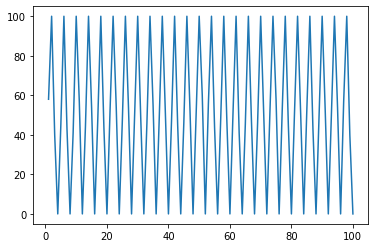

In [52]:
plt.plot(ns, signal_wo_noise)

On the other hand, if our `S` has some finite amplitude damping noise, then we'll eventually see this signal decay:

In [53]:
S = qt.Qobj([
    [1, 0],
    [0, 1j]
])

In [54]:
noise_model = qsharp.experimental.get_noise_model_by_name('ideal')
noise_model['h'] = (
    depolarizing_noise(0.025) *
    qt.to_super(qt.qip.operations.hadamard_transform())
)
noise_model['s'] = (
    amplitude_damping_noise(0.025) *
    qt.to_super(S)
)
qsharp.experimental.set_noise_model(noise_model)

In [55]:
# Note that this cell can take a few moments to run.
signal = [
    sum(ApplySRepeatedlyAndMeasure.simulate_noise(nRepetions=n) for _ in range(100))
    for n in ns
]

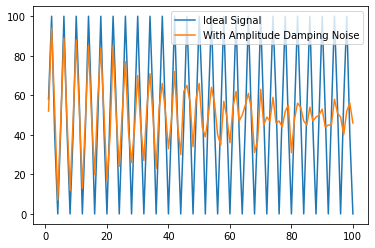

In [56]:
plt.plot(ns, signal_wo_noise, label='Ideal Signal')
plt.plot(ns, signal, label='With Amplitude Damping Noise')
plt.legend()

## Next steps

Having explored a bit of how to represent and simulate open quantum systems, there's a lot of great resources out there to help you take the next steps along your journey!

Here's a couple suggestions for some great places to look for next steps:

- [QuTiP documentation: Superoperators and Vectorized Operators](https://qutip.org/docs/latest/guide/guide-states.html#superoperators-and-vectorized-operators)
- [Characterization, Verification and Control for Large Quantum Systems: Chapter 1](https://uwspace.uwaterloo.ca/bitstream/handle/10012/9217/Granade_Christopher.pdf)
- [_Theory of Quantum Information_](https://cs.uwaterloo.ca/~watrous/TQI/)

## Epilogue

In [57]:
qsharp.component_versions()

{'iqsharp': LooseVersion ('0.17.210628040-alpha'),
 'Jupyter Core': LooseVersion ('1.5.0.0'),
 '.NET Runtime': LooseVersion ('.NETCoreApp,Version=v3.1'),
 'qsharp': LooseVersion ('0.17.2106.27950a1'),
 'experimental': {'simulators': {'features': ['DEFAULT'],
   'name': 'Microsoft.Quantum.Experimental.Simulators',
   'opt_level': '3',
   'target': 'x86_64-pc-windows-msvc',
   'version': '0.17.210628040-alpha'}}}